# 11.2.2 Pyspark example

This is a simple pyspark script that you can run locally or otherwise, provided that you have have a working Spark, pyspark and Jupyter configuration. See [Install notes](install_notes.txt) for details.

## Generic setup of a Spark Context

This is an essential component for every spark program. We are initialising it to allow for parallel computation.

In [1]:
from pyspark import SparkContext
sc = SparkContext("local", "first app")

In [2]:
print(SparkContext.version)

In [3]:
%matplotlib inline 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

## Spark and output

Spark assumes that you've done your homework and made sure that the output location is clear.

This is often not the case when you are experimenting. You will therefore want to include provision for removing content that gets in the way.

Note that you cannot do this easily from within Spark. It is best done from the OS or from python before you access the SparkContext.

### A useful function to clear the output path

In [4]:
from shutil import rmtree
import os
def clearaway(dir):
    if os.path.exists(dir):
        rmtree(dir)

## 11.2.2.1 parallelize input and output


This is a "first example" to show how input and output work in pyspark. Equivelent to `2.1-SparkInputOutput.py`.

In [5]:
## Distribute data over a spark context
samples = sc.parallelize([
    ("abonsanto@fakemail.com", "Alberto", "Bonsanto"),
    ("mbonsanto@fakemail.com", "Miguel", "Bonsanto"),
    ("stranger@fakemail.com", "Stranger", "Weirdo"),
    ("dbonsanto@fakemail.com", "Dakota", "Bonsanto")
])

## Collect the data (a sequential operation)
print(samples.collect())

clearaway("output/folder")
## Save the data (a parallel operation)
samples.saveAsTextFile("output/folder/here.txt")
## Load the data (a parallel operation)
read_rdd = sc.textFile("output/folder/here.txt")
## Collect the data again
print(read_rdd.collect())

[('abonsanto@fakemail.com', 'Alberto', 'Bonsanto'), ('mbonsanto@fakemail.com', 'Miguel', 'Bonsanto'), ('stranger@fakemail.com', 'Stranger', 'Weirdo'), ('dbonsanto@fakemail.com', 'Dakota', 'Bonsanto')]
["('abonsanto@fakemail.com', 'Alberto', 'Bonsanto')", "('mbonsanto@fakemail.com', 'Miguel', 'Bonsanto')", "('stranger@fakemail.com', 'Stranger', 'Weirdo')", "('dbonsanto@fakemail.com', 'Dakota', 'Bonsanto')"]


## 11.2.2.2 Exploiting RDD builtin functions

RDDs have many useful functions. Count is one that is implemented efficiently in parallel.

This is implemented in `2.2-SparkCount.py`.

In [6]:
words = sc.parallelize (
   ["scala", 
   "java", 
   "hadoop", 
   "spark", 
   "akka",
   "spark vs hadoop", 
   "pyspark",
   "pyspark and spark"]
)
## Count is parallelized
counts = words.count()
print("Number of elements in RDD -> %i" % (counts))

Number of elements in RDD -> 8


## 11.2.2.3 Accessing information about the Spark environment

Pyspark has very many ways to access the details; `StorageLevel` is one, that describes the redundancy of the replication. You should investigate the other information available, e.g. [pyspark for beginners](https://www.tutorialspoint.com/pyspark/pyspark_storagelevel.htm).

This is implemented in `2.3-SparkStorageLevel.py`.

In [7]:
logFile = "data/books/5720.txt"  
logData = sc.textFile(logFile).cache()
numAs = logData.filter(lambda s: 'a' in s).count()
numBs = logData.filter(lambda s: 'b' in s).count()
print ("Lines with a: %i, lines with b: %i" % (numAs, numBs))

Lines with a: 1799, lines with b: 741


In [8]:
from pyspark import StorageLevel

# Parallelize an RDD
rdd1 = sc.parallelize([1,2])
## Set its storage level to "2x replicated on memory and disk"
rdd1.persist(StorageLevel.MEMORY_AND_DISK_2 )
## Get this report
rdd1.getStorageLevel()
print(rdd1.getStorageLevel())

Disk Memory Serialized 2x Replicated


## 11.2.2.4 A simple filter

Filtering is the best thing to do with distributed data as it can return a manageable amount of data. This is trivially achieved via a `filter`, as in the following.

This is implemented in `2.4-ReadAndFilter.py`.

## 11.2.2.5 Machine Learning from within PySpark

For data science, the real joy of spark is distributed machine learning.

The main library is called `mllib` and it contains many useful functions; see e.g. [Mllib for beginners](https://www.tutorialspoint.com/pyspark/pyspark_mllib.htm).

This is implemented in `2.5-MLlibRecommender.py`.

In [9]:
from __future__ import print_function
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

clearaway("output/tmp/myCollaborativeFilter") 

## Here we have to be careful to protect workers so that they receive instruction from the main thread.
if __name__ == "__main__":
   data = sc.textFile("data/test_data.csv")
    ## Map data from a string into a Rating of person i of data j
   ratings = data.map(lambda l: l.split(','))\
      .map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
   
   # Build the recommendation model using Alternating Least Squares
   rank = 10
   numIterations = 10
   model = ALS.train(ratings, rank, numIterations)
   
   # Evaluate the model on training data
   testdata = ratings.map(lambda p: (p[0], p[1]))
   predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
   ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
   MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
   print("Mean Squared Error = " + str(MSE))
   
   # Save and load model
   model.save(sc, "output/tmp/myCollaborativeFilter")
   sameModel = MatrixFactorizationModel.load(sc, "output/tmp/myCollaborativeFilter")


Mean Squared Error = 8.3301452199873e-06


## 11.2.2.6 MapReduce Example to count word frequencies

The wonderful thing about Spark is that it will parallelise serial content, and retain any parallelisation available in sequential content. So if we provide it with data stored on HDFS, it stays that way, with no additional effort.

We can create a parallelised interface from a regular file structure just by reading many files at once.

Here we use Map Reduce from PySpark taking advantage of this structure.

This is implemented in `2.6-MapReduceWordcount`.

In [10]:
import re
clearaway("output/pyspark_wc") 

#text_file = sc.textFile("hdfs/books/*.txt")
text_file = sc.textFile("data/books/*.txt")
def linesplit(line):
    line = re.sub(r'[^\w\s]','',line)
    return(line.split(" "))

counts = text_file.flatMap(linesplit) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b)

counts.saveAsTextFile("output/pyspark_wc")


In [11]:
counts.collect()

[('Richmond', 43),
 ('solus', 3),
 ('Alarums', 3),
 ('Warre', 17),
 ('fearfull', 8),
 ('Cheated', 1),
 ('lamely', 3),
 ('halt', 7),
 ('Shadow', 5),
 ('closely', 7),
 ('which', 408),
 ('shall', 744),
 ('comes', 179),
 ('safety', 21),
 ('George', 39),
 ('Alacke', 10),
 ('O', 458),
 ('may', 447),
 ('protest', 16),
 ('Wizard', 1),
 ('followes', 17),
 ('Lady', 192),
 ('harsh', 8),
 ('there', 559),
 ('From', 85),
 ('heauen', 82),
 ('secure', 6),
 ('was', 1601),
 ('tell', 308),
 ('selfe', 393),
 ('Since', 33),
 ('dubd', 1),
 ('Gossips', 4),
 ('soeuer', 3),
 ('any', 251),
 ('speake', 223),
 ('wise', 31),
 ('Noble', 112),
 ('', 907),
 ('alone', 82),
 ('path', 3),
 ('Heauen', 35),
 ('they', 668),
 ('pitty', 36),
 ('play', 71),
 ('melancholly', 8),
 ('consumd', 4),
 ('Till', 44),
 ('When', 212),
 ('load', 8),
 ('Honor', 56),
 ('Herse', 1),
 ('Poore', 23),
 ('Be', 114),
 ('Ghost', 15),
 ('poore', 142),
 ('Stabd', 2),
 ('Whose', 58),
 ('interred', 1),
 ('stop', 25),
 ('Hell', 12),
 ('body', 57),
 (

## 11.2.2.7 A working machine learning pipeline


In [12]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## See https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

## Interactive session

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('data/bank.csv', header = True, inferSchema = True)
df.printSchema()

## Converting to pandas
pd.DataFrame(df.take(5), columns=df.columns).transpose()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [13]:
## Using the spark RDS describe
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [14]:
## Two ways to sample 1000 random points
## The recommended way, though you have to specify two limits (the fraction, here 0.5, and the number, here 1000, if needed)
## This way creates a spark RDD
numeric_data1=df.sample(False, 0.5, seed=0).limit(1000)
numeric_data = numeric_data1.toPandas()
numeric_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
1,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
2,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
3,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
4,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37,entrepreneur,single,secondary,no,-22,yes,no,cellular,15,may,317,1,-1,0,unknown,yes
996,39,admin.,divorced,secondary,no,878,yes,no,cellular,15,may,611,5,-1,0,unknown,yes
997,40,admin.,married,secondary,no,2574,yes,no,cellular,15,may,432,1,176,1,failure,yes
998,31,management,single,tertiary,no,2734,yes,no,cellular,15,may,858,3,-1,0,unknown,yes


In [15]:
## This way does a "collect", which can be slow in larger datasets, but is more natural
numeric_data2=df.rdd.takeSample(False, 1000, seed=0)
numeric_data2

[Row(age=60, job='retired', marital='married', education='primary', default='no', balance=600, housing='no', loan='no', contact='cellular', day=19, month='aug', duration=99, campaign=6, pdays=-1, previous=0, poutcome='unknown', deposit='no'),
 Row(age=43, job='admin.', marital='single', education='secondary', default='no', balance=733, housing='yes', loan='no', contact='cellular', day=21, month='aug', duration=126, campaign=1, pdays=88, previous=4, poutcome='success', deposit='yes'),
 Row(age=24, job='management', marital='married', education='secondary', default='no', balance=2278, housing='yes', loan='no', contact='unknown', day=27, month='may', duration=77, campaign=4, pdays=-1, previous=0, poutcome='unknown', deposit='no'),
 Row(age=31, job='technician', marital='single', education='secondary', default='no', balance=628, housing='yes', loan='no', contact='unknown', day=12, month='may', duration=1083, campaign=2, pdays=-1, previous=0, poutcome='unknown', deposit='no'),
 Row(age=52, 

Scatter matrices are a good go-to plot to understand the structure 

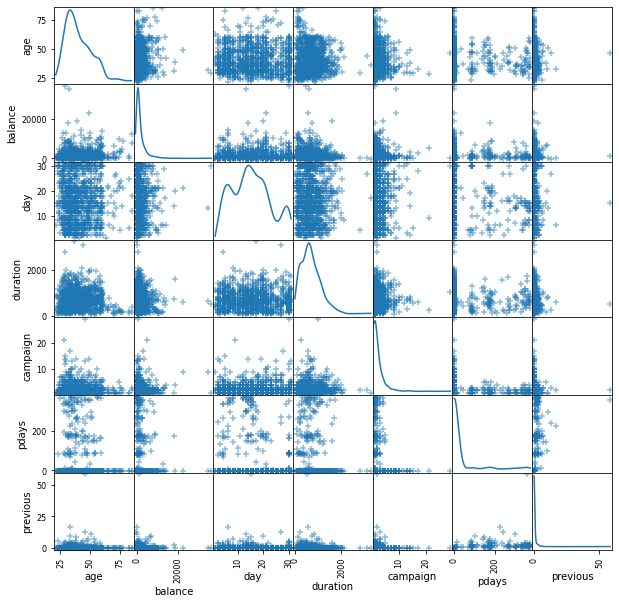

In [16]:
ax=pd.plotting.scatter_matrix(numeric_data, diagonal='kde', marker='+')

In [17]:
####################
## Preparing the data
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [18]:
## Getting rid of useless columns
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [19]:
stages

[StringIndexer_73ec73ca52d5,
 OneHotEncoder_d006deafd7cb,
 StringIndexer_30ffb1a8d264,
 OneHotEncoder_2be675326a28,
 StringIndexer_30213d0e4dba,
 OneHotEncoder_dcaa78d59185,
 StringIndexer_f2e027305130,
 OneHotEncoder_1fb39b4682eb,
 StringIndexer_0c098b6755fe,
 OneHotEncoder_a732e6233dbe,
 StringIndexer_bf681e15f88d,
 OneHotEncoder_bc823670a1f8,
 StringIndexer_e51bc29e104d,
 OneHotEncoder_76e3be624895,
 StringIndexer_71b95df54705,
 OneHotEncoder_75851de14c4e,
 StringIndexer_c810b39ca491,
 VectorAssembler_3744ce0eaab1]

In [20]:

#######################
## Making a "data processing pipeline"

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [21]:

#######################
## Look at a couple of rows
pd.DataFrame(df.take(5), columns=df.columns).transpose()


,0,1,2,3,4
label,1.0,1.0,1.0,1.0,1.0
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [22]:

#######################
## Do a standard training/ testing split
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 7855
Test Dataset Count: 3307


In [23]:
#######################
## Fit a logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)

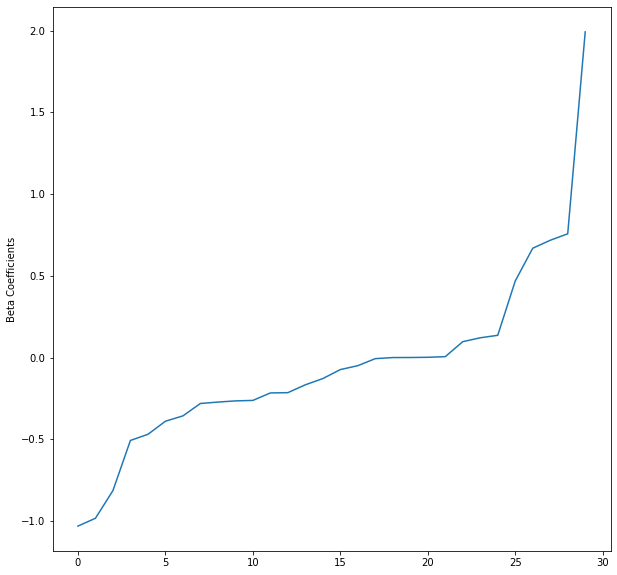

In [24]:
#######################
## Plot the results
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig('output/bank_betas.png')
#plt.close()
plt.show()
plt.close()

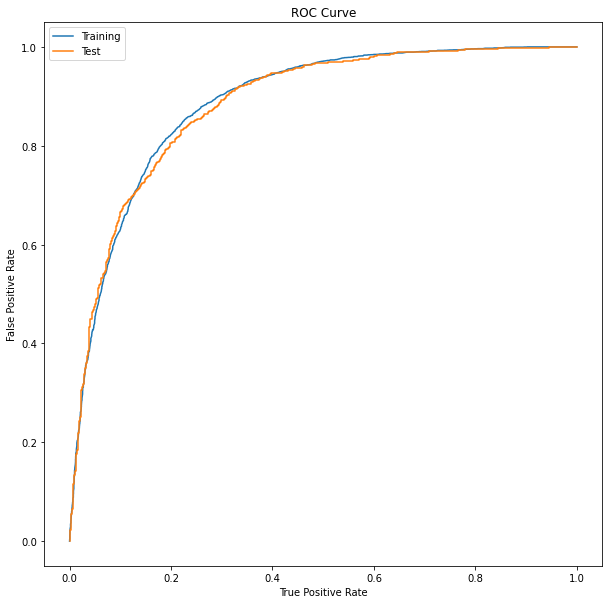

Training set areaUnderROC: 0.8865551189326405


In [25]:

######################
## ROC curves

trainingSummary = lrModel.summary

predpandas=predictions.select(['label','probability']).toPandas()
predpandas['probability']=[x[1] for x in predpandas['probability']]
from sklearn.metrics import roc_curve
testrocarray = roc_curve(predpandas['label'], predpandas['probability'])
testroc = pd.DataFrame.from_records(testrocarray).transpose()
testroc.columns=['FPR','TPR','Thresh']

trainroc = trainingSummary.roc.toPandas()

plt.plot(trainroc['FPR'],trainroc['TPR'],label='Training')
plt.plot(testroc['FPR'],testroc['TPR'],label='Test')
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('output/banks_roc.png')
plt.show()
plt.close()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


## 11.2.2.8 Broadcast

You might want to update all worker nodes with new information, e.g. hyperparameter values, etc. To do this you can use a **Broadcast** which simply assigns the variable to all worker nodes.

This is implemented in `Supplement/pys_broadcast.py` as it is so trivially explored.

In [26]:
words_new = sc.broadcast(["scala", "java", "hadoop", "spark", "akka"])
data = words_new.value
print ("Stored data -> %s" % (data) )
elem = words_new.value[2]
print ("Printing a particular element in RDD -> %s" % (elem))

Stored data -> ['scala', 'java', 'hadoop', 'spark', 'akka']
Printing a particular element in RDD -> hadoop


## Supplementary materials

For completeness, additional material are placed in `Supplement` and include:
    
* pys_filter.py: A simple example of filtering
* pys_map.py: A simple example of Map
* pys_collect.py: A simple example of a Collect
